# MLI

## 0.Import Data

In [54]:
import pandas as pd
import numpy as np
import lime
import lime.lime_tabular

In [55]:
path = "../Processed_Data/"
outpath = "../PredictionResult/"

In [56]:
# y
label_risk_company_sample = pd.read_csv("../Data/Online_Data/trainning_data/label_risk_company.csv”)

# X
company_ar = pd.read_csv(path+"company_ar_processed.csv")
company_ar_alterstockinfo = pd.read_csv(path+"company_ar_alterstockinfo_processed.csv")
company_ar_assetsinfo = pd.read_csv(path+"company_ar_assetsinfo_processed.csv")
company_ar_nz = pd.read_csv(path+"company_ar_nz_processed.csv")
#company_ar_socialfee = pd.read_csv(path+"company_ar_socialfee_processed.csv")
company_base_info = pd.read_csv(path+"company_base_info_processed.csv")
company_base_info_bef = pd.read_csv(path+"company_base_info.csv")
company_modify = pd.read_csv(path+"company_modify_processed.csv")
el_company_history_inv = pd.read_csv(path+"el_company_history_inv_processed.csv")
el_company_history_manager = pd.read_csv(path+"el_company_history_manager_processed.csv")
tax_abnormal = pd.read_csv(path+"tax_abnormal_processed.csv")
tax_company = pd.read_csv(path+"tax_company_processed.csv")
tax_qianshui = pd.read_csv(path+"tax_qianshui_processed.csv")
tax_year = pd.read_csv(path+"tax_year_processed.csv")

df_list =[company_ar_nz,company_base_info,el_company_history_manager,company_modify,
         tax_company,tax_year]

## 1.Join Tables

In [58]:
df =label_risk_company_sample
for i in df_list:
    df = pd.merge(df, i , on="entid",how='outer').copy()
df_all = df.copy()
df_all_2 = df.copy()
df = df.dropna(subset=["CaseType","id"])
df = df.drop(["id"],axis=1)

df = df.fillna(0)
df = df.drop_duplicates()
entid_list = df["entid"].values
#df = df.drop(["entid"],axis=1)
colname = df.columns.values
df

In [60]:
df = df.fillna(0)
df 

CaseType  Vol/transaction_per_year  net_change_per_year  \
0            3                       0.0                  0.0   
1            3                       0.0                  0.0   
2            0                       0.0                  0.0   
3            3                       0.0                  0.0   
4            2                       0.0                  0.0   
...        ...                       ...                  ...   
2051         3                       0.0                  0.0   
2052         3                       0.0                  0.0   
2053         3                       0.0                  0.0   
2054         3                       0.0                  0.0   
2055         3                       0.0                  0.0   

      unique_number_of_SH_involved_per_year  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
2051                                    0.0   
2052                                    0.0   
2053                                    0.0   
2054                                    0.0   
2055                                    0.0   

      total_transaction_number_per_year    ASSGRO   LIAGRO   VENDINC  \
0                                   0.0  0.000000  0.00000  0.000000   
1                                   0.0  0.000000  0.00000  0.000000   
2                                   0.0  0.060241  0.06944 -0.788483   
3                                   0.0  0.000000  0.00000  0.000000   
4                                   0.0  0.000000  0.00000  0.000000   
...                                 ...       ...      ...       ...   
2051                                0.0  0.000000  0.00000  0.000000   
2052                                0.0  0.000000  0.00000  0.000000   
2053                                0.0  0.000000  0.00000  0.000000   
2054                                0.0  0.000000  0.00000  0.000000   
2055                                0.0  0.000000  0.00000  0.000000   

      MAIBUSINC    PROGRO  ...  other_operating_cost  retained_profits  \
0      0.000000  0.000000  ...              0.000000          0.000000   
1      0.000000  0.000000  ...             -0.681896          0.861137   
2      1.012436  0.994677  ...              0.000000          0.000000   
3      0.000000  0.000000  ...              0.000000          0.000000   
4      0.000000  0.000000  ...              0.444446          0.134651   
...         ...       ...  ...                   ...               ...   
2051   0.000000  0.000000  ...              0.000000          0.000000   
2052   0.000000  0.000000  ...              0.000000          0.000000   
2053   0.000000  0.000000  ...              0.000000          0.000000   
2054   0.000000  0.000000  ...              1.110127          0.243137   
2055   0.000000  0.000000  ...              0.000000          0.000000   

      gross_profit  main_business_gross  incometax_actual  profit_margin  \
0              0.0                  0.0          0.000000       0.000000   
1              0.0                  0.0         -0.151294       7.862067   
2              0.0                  0.0          0.000000       0.000000   
3              0.0                  0.0          0.000000       0.000000   
4              0.0                  0.0         -0.430861       0.879706   
...            ...                  ...               ...            ...   
2051           0.0                  0.0          0.000000       0.000000   
2052           0.0                  0.0          0.000000       0.000000   
2053           0.0                  0.0          0.000000       0.000000   
2054           0.0                  0.0          0.023342       0.075084   
2055           0.0                  0.0          0.000000       0.0000

In [61]:
df.to_csv("df.csv")

<AxesSubplot:>

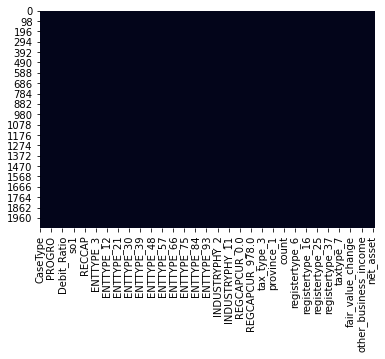

In [62]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)

## 2.Split

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import lightgbm as lgb

RANDOM_STATE = 42

In [65]:
X = df.drop("CaseType", axis=1)
y = df["CaseType"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE) 

## 3.Train Model

In [66]:
model = XGBClassifier()
model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
accuracy_score(y_test, pred)

0.9150485436893204

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.25      0.10      0.14        10
           2       0.53      0.53      0.53        17
           3       0.94      0.98      0.96       376

    accuracy                           0.92       412
   macro avg       0.43      0.40      0.41       412
weighted avg       0.88      0.92      0.90       412



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## 4.Shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


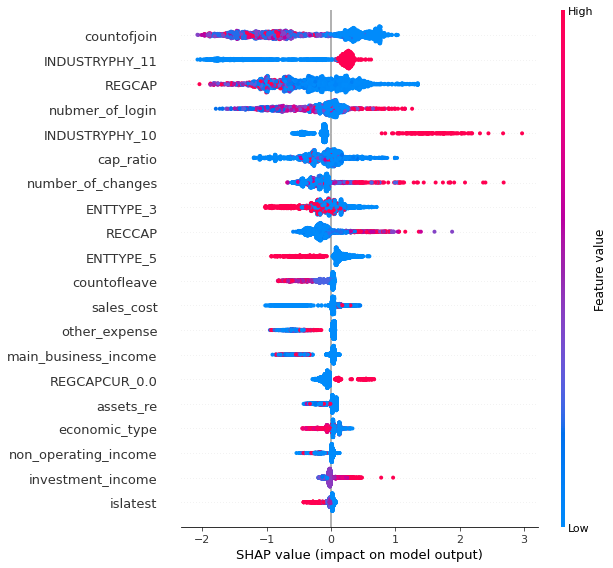

In [69]:
import shap
# load JS visualization code to notebook
shap.initjs()

# ticker_list = df.ticker.unique()

j = 'aapl'

# Variable Importance Plot

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# # summarize the effects of all the features
# shap.summary_plot(shap_values, X)

#We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

# explain the effects of all the features and distribution
import matplotlib.pyplot as plt

shap.summary_plot(shap_values[0], X)
print(' ')

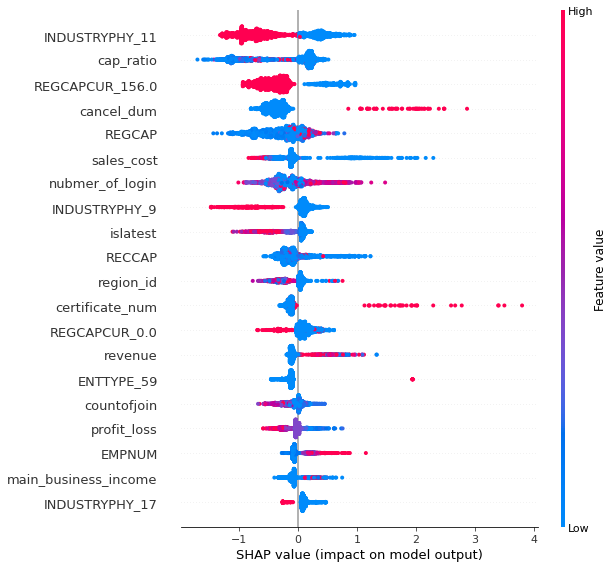

In [70]:
import shap
# load JS visualization code to notebook
shap.initjs()

# ticker_list = df.ticker.unique()

j = 'aapl'

# Variable Importance Plot

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# # summarize the effects of all the features
# shap.summary_plot(shap_values, X)

#We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

# explain the effects of all the features and distribution
import matplotlib.pyplot as plt

shap.summary_plot(shap_values[1], X)
print(' ')

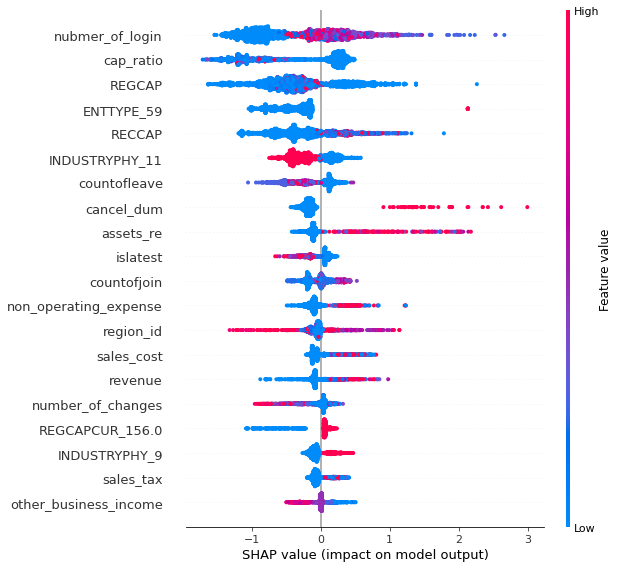

In [71]:
import shap
# load JS visualization code to notebook
shap.initjs()

# ticker_list = df.ticker.unique()

j = 'aapl'

# Variable Importance Plot

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# # summarize the effects of all the features
# shap.summary_plot(shap_values, X)

#We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

# explain the effects of all the features and distribution
import matplotlib.pyplot as plt

shap.summary_plot(shap_values[2], X)
print(' ')

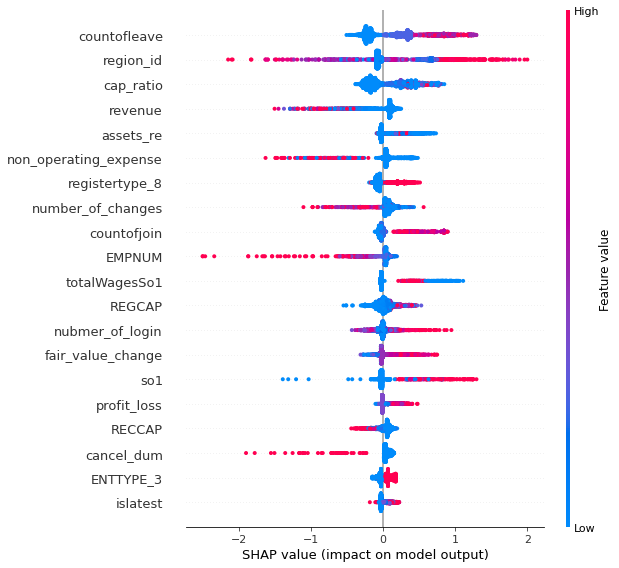

In [72]:
import shap
# load JS visualization code to notebook
shap.initjs()

# ticker_list = df.ticker.unique()

j = 'aapl'

# Variable Importance Plot

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# # summarize the effects of all the features
# shap.summary_plot(shap_values, X)

#We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

# explain the effects of all the features and distribution
import matplotlib.pyplot as plt

shap.summary_plot(shap_values[3], X)
print(' ')

In [73]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_train.iloc[79:80,:])
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[3], X_train.iloc[79:80,:])

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


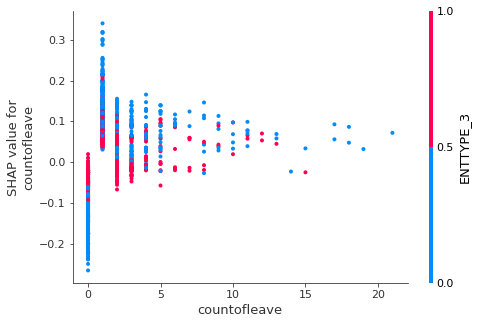

In [74]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# # summarize the effects of all the features
# shap.summary_plot(shap_values, X)

#We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

# explain the effects of all the features and distribution
import matplotlib.pyplot as plt

# shap.summary_plot(shap_values[0], X)

# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("countofleave", shap_values[1], X)

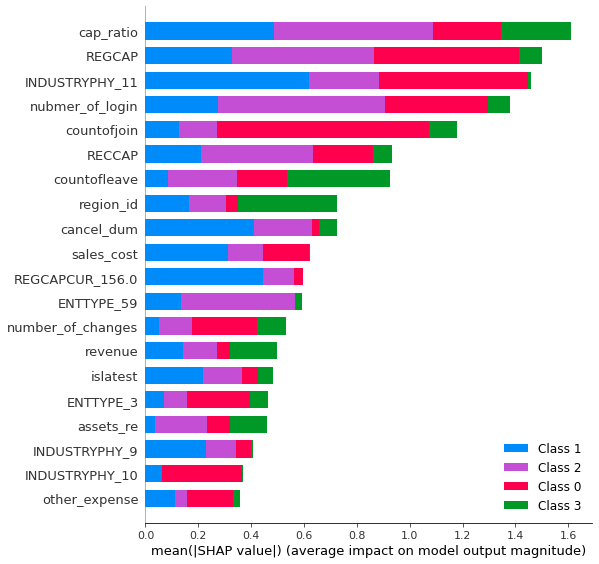

In [75]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

## 5.LIME

In [76]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification',feature_names= df.columns,class_names=["Legal Risk","Other Risk","Loan Risk","Operational Risk"])
explainer

In [77]:
exp = explainer.explain_instance(pd.DataFrame(X_train).iloc[1],model.predict_proba , num_features=10, top_labels=3)
exp.show_in_notebook(show_table = True)

In [79]:
#80
exp = explainer.explain_instance(pd.DataFrame(X_test).iloc[80,:],model.predict_proba , num_features=10, top_labels=3)
exp.show_in_notebook(show_table = True)

## 6.PFI

In [22]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [25]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{colname[i]:<8}"
               f"_"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

ENTTYPE_4_0.006 +/- 0.002
assets_re_0.002 +/- 0.000


In [26]:
df

CaseType  Vol/transaction_per_year  net_change_per_year  \
0            3                       0.0                  0.0   
1            3                       0.0                  0.0   
2            0                       0.0                  0.0   
3            3                       0.0                  0.0   
4            2                       0.0                  0.0   
...        ...                       ...                  ...   
2051         3                       0.0                  0.0   
2052         3                       0.0                  0.0   
2053         3                       0.0                  0.0   
2054         3                       0.0                  0.0   
2055         3                       0.0                  0.0   

      unique_number_of_SH_involved_per_year  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
2051                                    0.0   
2052                                    0.0   
2053                                    0.0   
2054                                    0.0   
2055                                    0.0   

      total_transaction_number_per_year    ASSGRO   LIAGRO   VENDINC  \
0                                   0.0  0.000000  0.00000  0.000000   
1                                   0.0  0.000000  0.00000  0.000000   
2                                   0.0  0.060241  0.06944 -0.788483   
3                                   0.0  0.000000  0.00000  0.000000   
4                                   0.0  0.000000  0.00000  0.000000   
...                                 ...       ...      ...       ...   
2051                                0.0  0.000000  0.00000  0.000000   
2052                                0.0  0.000000  0.00000  0.000000   
2053                                0.0  0.000000  0.00000  0.000000   
2054                                0.0  0.000000  0.00000  0.000000   
2055                                0.0  0.000000  0.00000  0.000000   

      MAIBUSINC    PROGRO  ...  other_operating_cost  retained_profits  \
0      0.000000  0.000000  ...              0.000000          0.000000   
1      0.000000  0.000000  ...             -0.681896          0.861137   
2      1.012436  0.994677  ...              0.000000          0.000000   
3      0.000000  0.000000  ...              0.000000          0.000000   
4      0.000000  0.000000  ...              0.444446          0.134651   
...         ...       ...  ...                   ...               ...   
2051   0.000000  0.000000  ...              0.000000          0.000000   
2052   0.000000  0.000000  ...              0.000000          0.000000   
2053   0.000000  0.000000  ...              0.000000          0.000000   
2054   0.000000  0.000000  ...              1.110127          0.243137   
2055   0.000000  0.000000  ...              0.000000          0.000000   

      gross_profit  main_business_gross  incometax_actual  profit_margin  \
0              0.0                  0.0          0.000000       0.000000   
1              0.0                  0.0         -0.151294       7.862067   
2              0.0                  0.0          0.000000       0.000000   
3              0.0                  0.0          0.000000       0.000000   
4              0.0                  0.0         -0.430861       0.879706   
...            ...                  ...               ...            ...   
2051           0.0                  0.0          0.000000       0.000000   
2052           0.0                  0.0          0.000000       0.000000   
2053           0.0                  0.0          0.000000       0.000000   
2054           0.0                  0.0          0.023342       0.075084   
2055           0.0                  0.0          0.000000       0.0000

In [30]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = df.drop("CaseType",axis=1).columns.tolist())

## 7.probability

In [462]:
X_test

entid  Vol/transaction_per_year  net_change_per_year  \
2053  1052219378                       0.0                  0.0   
1647    37110881                       0.0                  0.0   
289    498948676                       0.0                  0.0   
485    380623635                       0.0                  0.0   
199    212531966                       0.0                  0.0   
...          ...                       ...                  ...   
835    860901481                       0.0                  0.0   
1743   690111956                       0.0                  0.0   
1955   779872233                       0.0                  0.0   
496    221129618                       0.0                  0.0   
1067   100724777                       0.0                  0.0   

      unique_number_of_SH_involved_per_year  \
2053                                    0.0   
1647                                    0.0   
289                                     0.0   
485                                     0.0   
199                                     0.0   
...                                     ...   
835                                     0.0   
1743                                    0.0   
1955                                    0.0   
496                                     0.0   
1067                                    0.0   

      total_transaction_number_per_year  ASSGRO  LIAGRO  VENDINC  MAIBUSINC  \
2053                                0.0     0.0     0.0      0.0        0.0   
1647                                0.0     0.0     0.0      0.0        0.0   
289                                 0.0     0.0     0.0      0.0        0.0   
485                                 0.0     0.0     0.0      0.0        0.0   
199                                 0.0     0.0     0.0      0.0        0.0   
...                                 ...     ...     ...      ...        ...   
835                                 0.0     0.0     0.0      0.0        0.0   
1743                                0.0     0.0     0.0      0.0        0.0   
1955                                0.0     0.0     0.0      0.0        0.0   
496                                 0.0     0.0     0.0      0.0        0.0   
1067                                0.0     0.0     0.0      0.0        0.0   

      PROGRO  ...  other_operating_cost  retained_profits  gross_profit  \
2053     0.0  ...              0.000000      0.000000e+00       0.00000   
1647     0.0  ...              0.000000      0.000000e+00       0.00000   
289      0.0  ...              1.128617     -1.734792e+05   88559.65411   
485      0.0  ...             -0.159726     -1.144181e+00       0.00000   
199      0.0  ...             -0.013810     -4.674216e+06  276375.05030   
...      ...  ...                   ...               ...           ...   
835      0.0  ...              0.652555     -3.300638e-02       0.00000   
1743     0.0  ...              0.000000      0.000000e+00       0.00000   
1955     0.0  ...             -0.565172     -1.570208e+00       0.00000   
496      0.0  ...              0.000000      0.000000e+00       0.00000   
1067     0.0  ...              0.505837     -3.141999e+05   43800.13782   

      main_business_gross  incometax_actual  profit_margin  \
2053         0.000000e+00          0.000000       0.000000   
1647         0.000000e+00          0.000000       0.000000   
289          2.145880e+06      62005.763850       0.010979   
485          0.000000e+00         -1.567094     -12.522151   
199          0.000000e+00         49.696858      -5.131139   
...                   ...               ...            ...   
835          0.000000e+00         -0.686606       0.844093   
1743         0.000000e+00          0.000000       0.000000   
1955         0.000000e+00         -0.900096       0.052466   
496          0.000000e+00          0.000000       0.000000   
1067         4.379980e+04         -0.286435      -1.433401   

      operating_profit_margin  other_expense  

In [463]:
df_prob = pd.DataFrame()
df_prob["entid"] = X_test["entid"]
df_prob["Risk_Prediction"] = model.predict(X_test)
df_prob["Probability_0"] = pd.DataFrame(model.predict_proba(X_test)).iloc[:,0].values
df_prob["Probability_1"] = pd.DataFrame(model.predict_proba(X_test)).iloc[:,1].values
df_prob["Probability_2"] = pd.DataFrame(model.predict_proba(X_test)).iloc[:,2].values
df_prob["Probability_3"] = pd.DataFrame(model.predict_proba(X_test)).iloc[:,3].values

In [464]:
imp_feat=["EMPNUM","countofleave","honor_num","illegad_num","REGCAP","RECCAP","main_biz_profit_margin","non_operating_income","sales_cost"]

for i in range(len(imp_feat)):
    df_prob[imp_feat[i]] =X_test[imp_feat[i]]

In [465]:
df_prob.to_csv("eample_for_fronmt.csv",index=False)

## 8.Clustering

In [620]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.drop(["CaseType"],axis=1))

In [621]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df_scaled)
dataset_low_dm = pca.transform(df_scaled)

In [622]:
df

CaseType  Vol/transaction_per_year  net_change_per_year  \
0            3                       0.0                  0.0   
1            3                       0.0                  0.0   
2            0                       0.0                  0.0   
3            3                       0.0                  0.0   
4            2                       0.0                  0.0   
...        ...                       ...                  ...   
2051         3                       0.0                  0.0   
2052         3                       0.0                  0.0   
2053         3                       0.0                  0.0   
2054         3                       0.0                  0.0   
2055         3                       0.0                  0.0   

      unique_number_of_SH_involved_per_year  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
2051                                    0.0   
2052                                    0.0   
2053                                    0.0   
2054                                    0.0   
2055                                    0.0   

      total_transaction_number_per_year    ASSGRO   LIAGRO   VENDINC  \
0                                   0.0  0.000000  0.00000  0.000000   
1                                   0.0  0.000000  0.00000  0.000000   
2                                   0.0  0.060241  0.06944 -0.788483   
3                                   0.0  0.000000  0.00000  0.000000   
4                                   0.0  0.000000  0.00000  0.000000   
...                                 ...       ...      ...       ...   
2051                                0.0  0.000000  0.00000  0.000000   
2052                                0.0  0.000000  0.00000  0.000000   
2053                                0.0  0.000000  0.00000  0.000000   
2054                                0.0  0.000000  0.00000  0.000000   
2055                                0.0  0.000000  0.00000  0.000000   

      MAIBUSINC    PROGRO  ...  other_operating_cost  retained_profits  \
0      0.000000  0.000000  ...              0.000000          0.000000   
1      0.000000  0.000000  ...             -0.681896          0.861137   
2      1.012436  0.994677  ...              0.000000          0.000000   
3      0.000000  0.000000  ...              0.000000          0.000000   
4      0.000000  0.000000  ...              0.444446          0.134651   
...         ...       ...  ...                   ...               ...   
2051   0.000000  0.000000  ...              0.000000          0.000000   
2052   0.000000  0.000000  ...              0.000000          0.000000   
2053   0.000000  0.000000  ...              0.000000          0.000000   
2054   0.000000  0.000000  ...              1.110127          0.243137   
2055   0.000000  0.000000  ...              0.000000          0.000000   

      gross_profit  main_business_gross  incometax_actual  profit_margin  \
0              0.0                  0.0          0.000000       0.000000   
1              0.0                  0.0         -0.151294       7.862067   
2              0.0                  0.0          0.000000       0.000000   
3              0.0                  0.0          0.000000       0.000000   
4              0.0                  0.0         -0.430861       0.879706   
...            ...                  ...               ...            ...   
2051           0.0                  0.0          0.000000       0.000000   
2052           0.0                  0.0          0.000000       0.000000   
2053           0.0                  0.0          0.000000       0.000000   
2054           0.0                  0.0          0.023342       0.075084   
2055           0.0                  0.0          0.000000       0.0000

In [623]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=10, random_state=42)
result = kmeans_model.fit(dataset_low_dm)

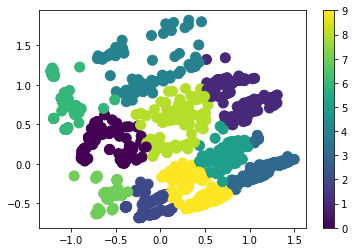

In [624]:
dataset_low_dm = pd.DataFrame(dataset_low_dm)

plt.scatter(dataset_low_dm.iloc[:,0], dataset_low_dm.iloc[:,1], s=100, c=result.labels_)
 
plt.colorbar()

## 9.Clarify Distance Relationship

In [625]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=11)
neigh.fit(df_scaled)
dist, ten_points_index = neigh.kneighbors([df_scaled[0]])

In [626]:
dist

array([[5.96046448e-08, 1.07464477e-01, 1.75611054e-01, 2.27131540e-01,
        3.08250384e-01, 3.25168994e-01, 3.77802652e-01, 1.01127249e+00,
        1.01458382e+00, 1.02962235e+00, 1.33743977e+00]])

In [627]:
# Distance
ten_points_index

array([[   0,  759,  160,  123, 1059, 1623,  429,  687, 1433, 1517,   74]],
      dtype=int64)

In [628]:
df

CaseType  Vol/transaction_per_year  net_change_per_year  \
0            3                       0.0                  0.0   
1            3                       0.0                  0.0   
2            0                       0.0                  0.0   
3            3                       0.0                  0.0   
4            2                       0.0                  0.0   
...        ...                       ...                  ...   
2051         3                       0.0                  0.0   
2052         3                       0.0                  0.0   
2053         3                       0.0                  0.0   
2054         3                       0.0                  0.0   
2055         3                       0.0                  0.0   

      unique_number_of_SH_involved_per_year  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
2051                                    0.0   
2052                                    0.0   
2053                                    0.0   
2054                                    0.0   
2055                                    0.0   

      total_transaction_number_per_year    ASSGRO   LIAGRO   VENDINC  \
0                                   0.0  0.000000  0.00000  0.000000   
1                                   0.0  0.000000  0.00000  0.000000   
2                                   0.0  0.060241  0.06944 -0.788483   
3                                   0.0  0.000000  0.00000  0.000000   
4                                   0.0  0.000000  0.00000  0.000000   
...                                 ...       ...      ...       ...   
2051                                0.0  0.000000  0.00000  0.000000   
2052                                0.0  0.000000  0.00000  0.000000   
2053                                0.0  0.000000  0.00000  0.000000   
2054                                0.0  0.000000  0.00000  0.000000   
2055                                0.0  0.000000  0.00000  0.000000   

      MAIBUSINC    PROGRO  ...  other_operating_cost  retained_profits  \
0      0.000000  0.000000  ...              0.000000          0.000000   
1      0.000000  0.000000  ...             -0.681896          0.861137   
2      1.012436  0.994677  ...              0.000000          0.000000   
3      0.000000  0.000000  ...              0.000000          0.000000   
4      0.000000  0.000000  ...              0.444446          0.134651   
...         ...       ...  ...                   ...               ...   
2051   0.000000  0.000000  ...              0.000000          0.000000   
2052   0.000000  0.000000  ...              0.000000          0.000000   
2053   0.000000  0.000000  ...              0.000000          0.000000   
2054   0.000000  0.000000  ...              1.110127          0.243137   
2055   0.000000  0.000000  ...              0.000000          0.000000   

      gross_profit  main_business_gross  incometax_actual  profit_margin  \
0              0.0                  0.0          0.000000       0.000000   
1              0.0                  0.0         -0.151294       7.862067   
2              0.0                  0.0          0.000000       0.000000   
3              0.0                  0.0          0.000000       0.000000   
4              0.0                  0.0         -0.430861       0.879706   
...            ...                  ...               ...            ...   
2051           0.0                  0.0          0.000000       0.000000   
2052           0.0                  0.0          0.000000       0.000000   
2053           0.0                  0.0          0.000000       0.000000   
2054           0.0                  0.0          0.023342       0.075084   
2055           0.0                  0.0          0.000000       0.0000

In [629]:
# Cosine similarity
cos_list=[]
source=[]
target=[]

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Reduced Output #

#ri = len(df_sclaed)
#rj = len(df_sclaed)
ri = 100
rj = 100

for i in range(ri):
    for j in range(rj):
        if i != j:
            cos_list.append(cos_sim(df_sclaed[i],df_sclaed[j]))
            source.append(entid_list[i])
            target.append(entid_list[j])

invalid value encountered in double_scalars


In [630]:
cos_df = pd.DataFrame()
cos_df["weight"] = cos_list
cos_df["source"] = source
cos_df["target"] = target

node_df = pd.DataFrame()
node_df["entid"]=list(set(source))
node_df = pd.merge(node_df, company_base_info_bef[["entid","ENTTYPE","INDUSTRYPHY"]] , on="entid",how='inner') 

In [631]:
cos_df

weight      source      target
0     0.323060  1189743165   881639012
1     0.591760  1189743165    40238525
2     0.617824  1189743165   325265909
3     0.009706  1189743165   908247590
4     0.004497  1189743165   534082754
...        ...         ...         ...
9895  0.000000   737891753   852094752
9896  0.000000   737891753  1085632906
9897  0.000000   737891753   242119654
9898  0.000000   737891753  1113017293
9899  0.000000   737891753  1067569329

[9900 rows x 3 columns]

In [632]:
#node_df.to_csv("node.csv",index=False)
#cos_df.to_csv("edgde.csv",index=False)

## 11.Pick Important Features For Similality

In [641]:
df_scaled = pd.concat([pd.DataFrame(entid_list,columns=["entid"]),pd.DataFrame(df_scaled,columns=colname[1:])] ,axis=1)

In [677]:
def imp_feat (source,target):
    list_dist = []
    for i in range(len(df_scaled.columns)-1):
        dist = abs(df_scaled[df_scaled["entid"] == source].iloc[:,i+1].values[0] - df_scaled[df_scaled["entid"] == target].iloc[:,i+1].values[0])
        list_dist.append(dist)
    return list_dist

In [704]:
def pick_top(lis,num):
    ind_list = []
    for i in range(num):
        sort = np.array(lis).argsort()
        ind_list.append(colname[1:][sort[-(1+i)]])
    return ind_list

In [705]:
pick_top(imp_feat (1189743165,881639012),3)

['ENTTYPE_22', 'registertype_8', 'INDUSTRYPHY_9']